# CO Radex grid visualizations

December 14, 2023

Test out visualizations using the Radex grid I ran for the CO lines.

Since this is pretty similar in theory to the PDR Toolbox, I can use some of their vizualizations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from astropy.io import fits
from astropy import units as u
from astropy.wcs import WCS
from reproject import reproject_interp

import pandas as pd
import cmocean

In [2]:
# Load the model grids
misc_data_path = "/home/ramsey/Documents/Research/Feedback/misc_data/co_grids"
grid_fn = "co_radex_grid_Tk30.0K_size0864.fits"
grid_full_fn = os.path.join(misc_data_path, grid_fn)
extname_key = 'EXTNAME'
grid_dict = {}
with fits.open(grid_full_fn) as hdul:
    for i, hdu in enumerate(hdul):
        if i == 0:
            assert extname_key not in hdu.header
        else:
            extname = hdu.header[extname_key]
            # print(i, extname)
            grid_dict[extname] = hdu.data * u.Unit(hdu.header['BUNIT'])

The extensions and their indices as of December 14, 2023 are:

In [3]:
# Figure out the plot extent stuff once and reuse it, it doesn't change
# Copied the basic code from `co_column_grid.ipynb`

# Extract the 1D indepedent arrays
cd_arr = grid_dict['NH2'][:, 0].to_value()
n_arr = grid_dict['n'][0, :].to_value()

def calc_extent(arr):
    diff = np.diff(arr)[0]
    tmp_arr = arr - diff/2
    return [tmp_arr[0], tmp_arr[-1]+diff]

# Extent array is (low x, high x, low y, high y), which is equivalent to (left right bottom top)
# xaxis is n_arr, yaxis is cd_arr, and log10 them both since grids are log spaced.
extent = calc_extent(np.log10(n_arr)) + calc_extent(np.log10(cd_arr))
# Just throw that into a "plot_kwargs" dict that also has origin='lower' so we can stop writing it so much
plot_kwargs = {'origin': 'lower', 'extent': extent,}

# Make a common plot configurer
def config_ax(ax):
    ax.set_xlabel("n [cm-3]")
    ax.set_ylabel("N(H2) [cm-2]")

# First plots, testing out the grid combinations

In [17]:
# Function that plots the images quickly
def plot_contour_only(key, ax, levels, img=None, cbar=None, **kwargs):
    """
    :param key: same as below
    :param ax: necessary in this case
    :param levels: one or more levels; necessary in this case
    :param img: shortcut to the key parsing exercise, if the image has already been created.
        If img is set, then key is ignored.
    :param cbar: colorbar instance, if levels are to be plotted. Leave as None to disable this.
    :param **kwargs: rest of kwargs sent to Axes.contour()
    """
    if img is None:
        if "/" in key:
            keys = [k.strip() for k in key.split("/")]
            imgs = [grid_dict[k] for k in keys]
            img = (imgs[0] / imgs[1]).to_value()
        else:
            img = grid_dict[key].to_value()
    contour_kwargs = {'colors': 'white', 'linewidths': 2}
    contour_kwargs |= kwargs # this allows kwargs keys to take precedence
    ax.contour(img, levels=levels, **plot_kwargs, **contour_kwargs)
    if cbar is not None:
        for l in levels:
            cbar.ax.axhline(l, color=contour_kwargs['colors'])

def plot_grid_image(key, ax=None, levels=None, cmap='viridis'):
    """
    :param key: string dict key to grid_dict.
        Can have a "/" in it (surrounded by spaces is ok)
        which will be used as a separator between two keys
        whose ratio will be plotted
    :param ax: Axes on which to plot. Otherwise, new fig, new ax
    :param levels: list of float values on the image at which to contour.
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 4))
        ax = plt.subplot(111)
    else:
        fig = plt.gcf()
    if "/" in key:
        keys = [k.strip() for k in key.split("/")]
        imgs = [grid_dict[k] for k in keys]
        img = (imgs[0] / imgs[1]).to_value()
    else:
        img = grid_dict[key].to_value()

    im = ax.imshow(img, **plot_kwargs, cmap=cmap)
    cbar = fig.colorbar(im, ax=ax, label=key)
    if levels is not None:
        plot_contour_only(None, ax, levels, img=img, cbar=cbar)
    config_ax(ax)

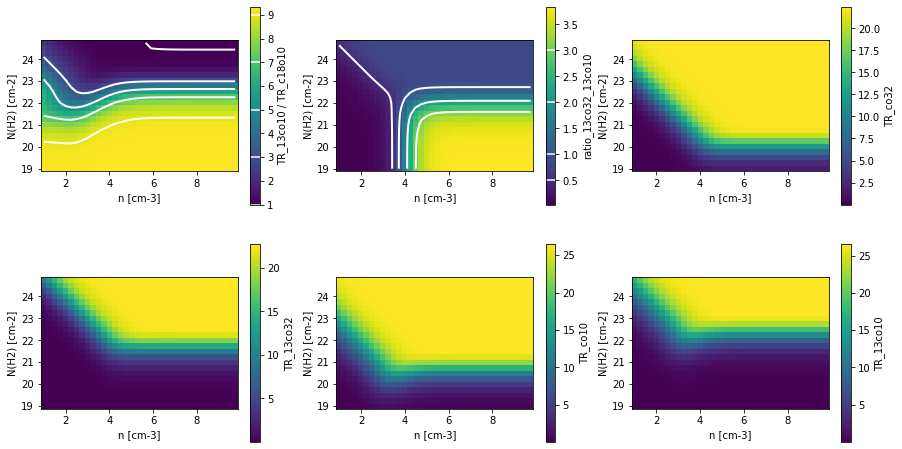

In [18]:
plt.figure(figsize=(15, 8))
plot_grid_image("TR_13co10 / TR_c18o10", levels=[1, 3, 5, 7, 9], ax=plt.subplot(231))
plot_grid_image("ratio_13co32_13co10", levels=[0.5, 1, 2, 3], ax=plt.subplot(232))
plot_grid_image('TR_co32', ax=plt.subplot(233))
plot_grid_image('TR_13co32', ax=plt.subplot(234))
plot_grid_image('TR_co10', ax=plt.subplot(235))
plot_grid_image('TR_13co10', ax=plt.subplot(236));

## Add data to image grid plots

Test sample data is in `misc_regrids/sample_points_test_1_11.0.21.0.csv`

The Herschel 70-160 column density as already been corrected to be N(H2), like the rest of them. The 160-500 was already in that format.

In [36]:
sample_data_fn = "/home/ramsey/Documents/Research/Feedback/m16_data/misc_regrids/sample_points_test_1_11.0.21.0.csv"

sample_data_df = pd.read_csv(sample_data_fn)
sample_data_df

,Unnamed: 0,reg_name,ratio_32_10,err_ratio_32_10,peak_13co32,peak_13co10,ratio_13_18,err_ratio_13_18,peak_c18o10,column_density_13co10,err_column_density_13co10,column_density_c18o10,err_column_density_c18o10,column_density_70-160,column_density_160-500,peak_12co32-pmo,peak_12co32
0,0,BNR-north-1,0.532672,0.018123,4.099059,6.671907,7.034859,1.513113,0.948407,9.458429e+21,3.158051e+20,9.430918e+21,2.355780e+21,3.331120e+22,2.181158e+22,13.158587,16.375483
1,1,BNR-north-2,0.602566,0.021247,4.265715,7.331823,5.809485,0.943261,1.262044,1.122170e+22,3.401019e+20,1.072297e+22,2.346246e+21,1.177692e+22,1.592683e+22,11.165926,10.010483
2,2,BNR-mid-1,0.706737,0.022939,5.162772,7.248931,8.360064,1.961197,0.867090,1.250062e+22,3.537903e+20,4.973670e+21,2.558162e+21,4.977577e+22,3.475733e+22,13.218234,15.920032
3,3,BNR-mid-2,1.240702,0.072354,4.526286,3.509741,8.502378,4.188727,0.412795,4.275431e+21,2.427186e+20,NaN,NaN,2.982888e+22,1.727047e+22,11.927839,15.736280
4,4,BNR-mid-3,0.323925,0.063725,0.563681,2.122951,8.605950,7.093562,0.246684,1.307665e+21,2.043746e+20,NaN,NaN,4.505063e+22,1.936837e+22,7.789230,8.444663
5,5,Eastern-cloud,0.421307,0.022556,2.302787,5.980305,5.764244,1.138745,1.037483,3.640086e+21,2.462715e+20,NaN,NaN,3.813748e+22,4.990437e+22,7.285845,8.246155


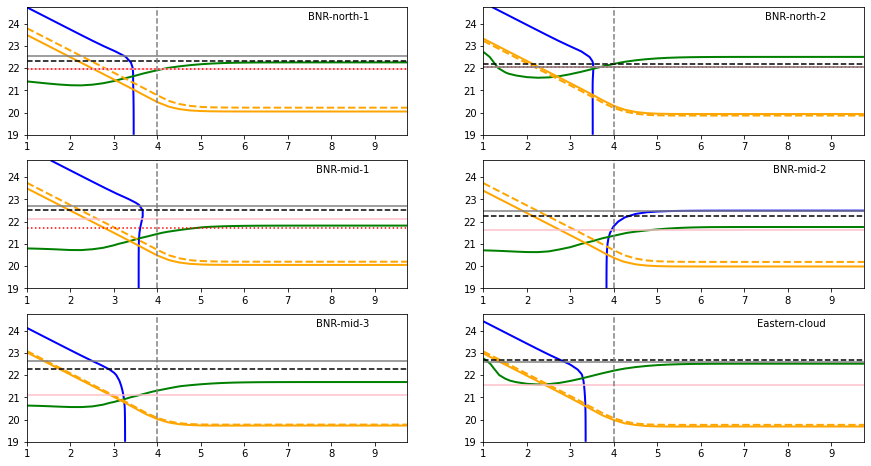

In [40]:
fig = plt.figure(figsize=(15, 8))

for i in range(6):
    ax = plt.subplot(3, 2, 1 + i)
    reg_select = i # just select by iloc for now
    sample_row = sample_data_df.iloc[reg_select]
    # ratio_32_10
    plot_contour_only("ratio_13co32_13co10", ax, levels=[sample_row["ratio_32_10"]], colors='b')
    plot_contour_only("TR_13co10 / TR_c18o10", ax, levels=[sample_row["ratio_13_18"]], colors='g')
    plot_contour_only("TR_co32", ax, levels=[sample_row['peak_12co32-pmo']], colors='orange')
    plot_contour_only("TR_co32", ax, levels=[sample_row['peak_12co32']], colors='orange', linestyles='--')
    column_colors = ['pink', 'r', 'grey', 'k']
    column_ls = ['-', ':', '-', '--']
    for j, column_key in enumerate(["column_density_13co10", "column_density_c18o10",
                                    "column_density_70-160", "column_density_160-500"]):
        ax.axhline(np.log10(sample_row[column_key]), color=column_colors[j], linestyle=column_ls[j])
    ax.text(0.9, 0.9, sample_row["reg_name"], transform=ax.transAxes, ha='right')
    ax.axvline(4, linestyle='--', color='grey')

# Scatter plot style

Try using the scatter plot style. Need to draw contours at each decade of N(H2) and n.

In [ ]:
# Create function for this so it's easier
def plot_two_grids(xgrid, ygrid, ax=None, cd_lims=None, n_lims=None):
    """
    xgrid will be the x axis value and so on
    cd_lims and n_lims should each be lists of 2 Quantities, [lo, hi] limits for plotting
    """
    if ax is None:
        plt.figure()
        ax = plt.subplot(111)
    # Make permissive limit lists if they're not specified
    if cd_lims is None:
        cd_lims = [-np.inf, np.inf] * grid_dict['NH2'].unit
    if n_lims is None:
        n_lims = [-np.inf, np.inf] * grid_dict['n'].unit
    # Within limits function for ease
    def within_lims(x, lims):
        return lims[0] <= x <= lims[1]
    # Do constant NH2
    for i in range(0, xgrid.shape[0], 4):
        # const nh2
        cd_val = grid_dict['NH2'][i, 0]
        if within_lims(cd_val, cd_lims):
            x = xgrid[i, :]
            y = ygrid[i, :]
            plt.plot(x, y, linestyle='-', label=f"{cd_val:.0E}")
    # Reset color cycle because the later colors are more difficult
    ax.set_prop_cycle(None)
    # Do constant n
    for j in range(0, xgrid.shape[1], 4):
        # const n
        n_val = grid_dict['n'][0, j]
        if within_lims(n_val, n_lims):
            x = xgrid[:, j]
            y = ygrid[:, j]
            plt.plot(x, y, linestyle='--', label=f"{n_val:.0E}")


In [ ]:
plt.figure(figsize=(8, 4))

# Let x be the 13 to 18 ratio of 1-0
# Let y be the 3-2/1-0 ratio of 13CO

xgrid = (grid_dict['TR_13co10'] / grid_dict['TR_c18o10']).to_value()
ygrid = (grid_dict['ratio_13co32_13co10']).to_value()

plot_two_grids(xgrid, ygrid, ax=plt.subplot(111))

plt.xlabel("13 / 18 ratio 1-0")
plt.ylabel("3-2 / 1-0 ratio 13CO");

# Loading and masking data

That looks cool, let me add data to that.

In [ ]:
# velocity_stub = "21.0.27.0"
velocity_stub = "11.0.21.0"

# 32/10 is used as the y axis
apex_path = "/home/ramsey/Documents/Research/Feedback/m16_data/apex"
co_32_10_ratio_fn = f"ratio_v2_13co_32_to_10_pmo_{velocity_stub}.fits"

# 13/18 is used as the x axis
pmo_path = "/home/ramsey/Documents/Research/Feedback/m16_data/purplemountain"
co_13_18_ratio_fn = f"ratio_13co_to_c18o_10_pmo_{velocity_stub}.fits"

fns = {
    'xratio': os.path.join(pmo_path, co_13_18_ratio_fn),
    'yratio': os.path.join(apex_path, co_32_10_ratio_fn)
}

data = {}

for k in fns:
    fn = fns[k]
    print(k, '\n', fn)
    with fits.open(fn) as hdul:
        for i, hdu in enumerate(hdul):
            if i > 0:
                print(i, hdu.header[extname_key])
    print()

In [ ]:
nsigma_cutoff = 3

# Reprojecting the data

I'll reload the data and reproject it before masking it this time

In [ ]:
# Break it up into functions

x_errs = (0.2, 0.202) # 13co10, c18o10
y_errs = (0.09, 0.2) # 13co32, 13co10

def load_ratio(x_or_y, err_tuple):
    """
    Load the ratio and two data panels, return them and their WCS
    Input their uncertainties, they won't be used but will be returned
    so that they can be easily matched with the data
    """
    loaded_data = {}
    with fits.open(fns[x_or_y + 'ratio']) as hdul:
        loaded_data["ratio"] = hdul[1].data
        loaded_data["err_ratio"] = hdul[2].data
        loaded_data['d0'] = hdul[3].data # numerator; 3rd
        loaded_data['e0'] = err_tuple[0]
        loaded_data['d1'] = hdul[4].data # denominator; 4th/last
        loaded_data['e1'] = err_tuple[1]
        loaded_data['wcs'] = WCS(hdul[1].header)
        loaded_data['shape'] = hdul[1].shape
    return loaded_data


def reproject_ratio(target_data, reference_data):
    """
    Reproject target data to the grid of reference data
    Replace target data; the old projected will not be saved
    Both inputs are dictionaries returned by load_ratio()
    The dictionaries are modified in-place, nothing is returned
    """
    old_wcs = target_data['wcs']
    ref_wcs = reference_data['wcs']
    ref_shape = reference_data['shape']
    for k in ['ratio', 'err_ratio', 'd0', 'd1']:
        img = target_data[k]
        target_data[k] = reproject_interp((img, old_wcs), ref_wcs, shape_out=ref_shape, return_footprint=False)
    target_data['wcs'] = ref_wcs
    target_data['shape'] = ref_shape


def mask_ratio_and_error(data):
    """
    Data is the dictionary returned by load_ratio
    """
    masks = []
    for i in range(2):
        mask = data[f"d{i}"] > data[f"e{i}"]*nsigma_cutoff
        masks.append(mask)
        data[f"mask{i}"] = mask
    # Combine masks and save to data dict
    mask = masks[0] & masks[1]
    data['mask'] = mask
    for k in ['ratio', 'err_ratio']:
        data[k+'_values'] = data[k][mask].flatten()
        data[k+'_masked'] = data[k].copy()
        data[k+'_masked'][~mask] = np.nan


def diagnostic_plot_1(data, reproj=None):
    """
    data is dict
    if reproj is None, no reproject. If reproj is another data dict, then data will be reprojected to it
    """
    if reproj is not None:
        assert isinstance(reproj, dict)
        reproject_ratio(data, reproj)
    ratio = data['ratio']
    mask_ratio_and_error(data)
    m0, m1 = data['mask0'], data['mask1']
    ratio_masked = data['ratio_masked']
    
    plt.figure(figsize=(12, 5))
    plt.subplot(231)
    plt.imshow(ratio, origin='lower')
    plt.subplot(232)
    plt.imshow(m0, origin='lower')
    plt.subplot(233)
    plt.imshow(m1, origin='lower')
    plt.subplot(234)
    plt.imshow(ratio_masked, origin='lower')
    plt.subplot(235)
    plt.hist(data['ratio_values'], bins=20)

def join_masks(data1, data2):
    """
    Data and masks must all be on the same grid
    Creates the "_values_2" key suffix for ratio, err_ratio
    """
    both_data = [data1, data2]
    combined_mask = data1['mask'] & data2['mask']
    for i, data in enumerate(both_data):
        for k in ['ratio', 'err_ratio']:
            data[k+'_values_2'] = data[k][combined_mask]

Test out these functions

In [ ]:
xdata, ydata = load_ratio('x', x_errs), load_ratio('y', y_errs)

In [ ]:
diagnostic_plot_1(ydata)

In [ ]:
diagnostic_plot_1(xdata, reproj=ydata)

In [ ]:
join_masks(xdata, ydata)

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(111)

select = 2
rand_start = 0
suffix = ""

if '27' in velocity_stub:
    color = 'blue'
else:
    color = 'k'

if select == 0:
    _, _, _, im = ax.hist2d(xdata['ratio_values_2'], ydata['ratio_values_2'], bins=32, cmap=cmocean.cm.matter)
    fig.colorbar(im, ax=ax)
    type_stub = "hist"
elif select == 1:
    ax.scatter(xdata['ratio_values_2'], ydata['ratio_values_2'], marker='.', alpha=0.02, c=color)
    type_stub = "scatter2"
elif select == 2:
    sl = slice(rand_start, None, 50)
    ax.errorbar(xdata['ratio_values_2'][sl], ydata['ratio_values_2'][sl],
                xerr=xdata['err_ratio_values_2'][sl], yerr=ydata['err_ratio_values_2'][sl],
               marker='.', linestyle='none', alpha=0.2, color=color)
    type_stub = "scatter"
    suffix = f"_samp{rand_start}"

plot_two_grids(xgrid, ygrid, ax=ax, cd_lims=[1e21, 1.1e23]*u.cm**-2, n_lims=[1e2, 1e5]*u.cm**-3)

ax.set_xlim((0, 14))
ax.set_ylim((0, 3))
ax.legend()

# plt.savefig(f"/home/ramsey/Pictures/2023-12-16/{type_stub}_ratio_{velocity_stub}.png");